In [28]:
# 정밀도 코드 구현

import tensorflow as tf
from keras.metrics import Metric, TruePositives, FalsePositives
from tensorflow.keras import backend as K

class MyMetric(Metric):

  def __init__(self, name="mymetric",**kwargs) :
    super().__init__(name=name,**kwargs)
    # tp 0으로 초기화
    self.true_positives = self.add_weight(name="tp", initializer="zeros")
    # fp 0으로 초기화
    self.false_positives = self.add_weight(name="fp", initializer="zeros")


  def update_state(self, y_true, y_pred, sample_weight=None):
	  # 예측 값, 실제 값 모두 True일 때의 개수 합산
    tp = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 1), tf.float32))
    # 예측 값 True, 실제 값 False일 때의 개수 합산
    fp = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 1), tf.float32))

    self.true_positives.assign_add(tp)
    self.false_positives.assign_add(fp)

  # 정밀도 측정
  # def result(self):
  #   return self.true_positives / (self.true_positives + self.false_positives)
  # 분모가 0일 때 nan출력 -> 작은 값으로 분모가 0이 되는 것을 방지

  def result(self):
      epsilon = 1e-7
      return self.true_positives / (self.true_positives + self.false_positives + epsilon)

	# 상태 초기화
  def reset_states(self):
    self.true_positives.assign(0)
    self.false_positives.assign(0)


In [29]:
# 베이스라인 코드 (영화 리뷰 이진 분류)

from tensorflow.keras.datasets import imdb
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

(train_data, train_labels), _ = imdb.load_data(num_words=10000)


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy",MyMetric()]) # 사용자 정의 평가 지표 적용
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6639 - loss: 0.6191 - mymetric: 0.0000e+00 - val_accuracy: 0.8700 - val_loss: 0.4202 - val_mymetric: 0.0000e+00
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8937 - loss: 0.3673 - mymetric: 0.0000e+00 - val_accuracy: 0.8555 - val_loss: 0.3517 - val_mymetric: 0.0000e+00
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9152 - loss: 0.2628 - mymetric: 0.0000e+00 - val_accuracy: 0.8925 - val_loss: 0.2857 - val_mymetric: 0.0000e+00
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9411 - loss: 0.1989 - mymetric: 0.0000e+00 - val_accuracy: 0.8801 - val_loss: 0.2945 - val_mymetric: 0.0000e+00
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9490 - loss: 0.1645 - mymetric: 0.0000e+00 - val_accuracy: 0.8890 - val_loss: 0.2825 - val_mymetric: 0.0000e+00
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9584 - loss: 0.1411 - mymetric: 0.1151 - val_accur

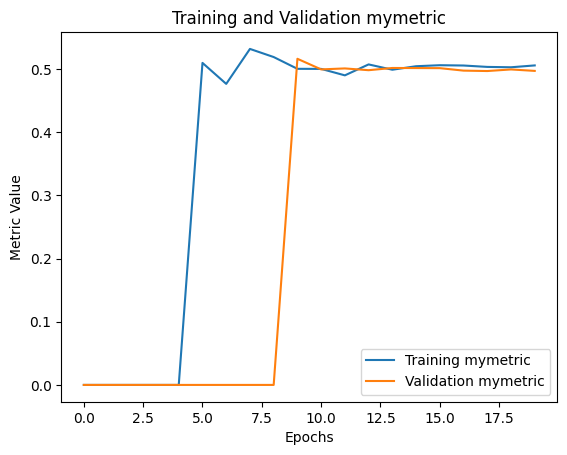

In [44]:
import matplotlib.pyplot as plt

plt.plot(history_original.history["mymetric"], label="Training mymetric")
plt.plot(history_original.history["val_mymetric"], label="Validation mymetric")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Training and Validation mymetric")
plt.show()